In [1]:
import os

# visualizing data
import warnings
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import torch
import torch.nn as nn
import numpy as np
from imblearn.over_sampling import SMOTE  
train_on_gpu = torch.cuda.is_available()
# train_on_gpu = False
if not train_on_gpu:
    print('CUDA is not available.')
else:
    print('CUDA is available.')

CUDA is available.


In [2]:
from torch.utils.data import DataLoader
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import pandas as pd

from skimage import io, transform
%matplotlib inline

In [3]:
from __future__ import print_function, division

from skimage import io, transform
from skimage.transform import rescale, resize, downscale_local_mean
from skimage.util import img_as_float, random_noise
from skimage.morphology import disk
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils


class ImageLoader(Dataset):
  

    def __init__(self, data_frame, transform=None, Is_tumor=False):

        self.data_frame = data_frame
        self.transform = transform
        self.filepath= 'C:/Users/13862/Desktop/AMLS_assignment/dataset/image/' 
        if Is_tumor:
            self.class_dic = {'meningioma_tumor':0,'glioma_tumor':0, 'pituitary_tumor':0, 'no_tumor':1}
        else:
            self.class_dic = {'meningioma_tumor':0,'glioma_tumor':1, 'pituitary_tumor':2, 'no_tumor':3}
        
    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
      
        image = io.imread(self.filepath + str(self.data_frame.iloc[idx, 0]), as_gray=True)
        labels = self.data_frame.iloc[idx, 1]
        labels = self.class_dic[str(labels)]
        labels = np.array(labels)
        labels = labels.astype(np.float)
        sample = {'image': image, 'labels': labels}

        if self.transform:
            sample = self.transform(sample)

        return sample
    


class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size_height,output_size_width):
        assert isinstance(output_size_height, (int, tuple))
        assert isinstance(output_size_width, (int, tuple))
        self.output_size_height = output_size_height
        self.output_size_width = output_size_width

    def __call__(self, sample):
        
            
              
        new_h, new_w = self.output_size_height,self.output_size_width
        new_h, new_w = int(new_h), int(new_w)
        
        image, labels = sample['image'], sample['labels']
        img = transform.resize(image, (new_h, new_w))
        
        
        return {'image': img, 'labels': labels}


    
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    


    def __call__(self, sample):
        image, labels = sample['image'], sample['labels']
        image = np.expand_dims(image, axis=2)
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'labels': torch.from_numpy(labels)}


    
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)).squeeze(2), cmap=plt.get_cmap('gray'))  # convert from Tensor image

# def imshow(img):
#     img = img / 2 + 0.5  # unnormalize
#     plt.imshow(np.transpose(img, (1, 2, 0))) 

In [4]:
filepath = 'C:/Users/13862/Desktop/AMLS_assignment/dataset/image/' 
pathidentity='C:/Users/13862/Desktop/AMLS_assignment/dataset/'+'label.csv'
Tumnor_detection=False

data = pd.read_csv(pathidentity)


df=data
np.random.seed(33)
df = shuffle(df)
part=len(df)//10
print(part)
df_train = df[:int(8*part)]
df_test = df[int(8*part):int(9*part)]
df_val = df[int(9*part):]
thesize=256

brain_dataset_train = ImageLoader(df_train,transform=transforms.Compose([
                                               Rescale(thesize,thesize),                                             
                                               ToTensor()
                                           ]),Is_tumor=Tumnor_detection)
brain_dataset_test = ImageLoader(df_test,transform=transforms.Compose([
                                               Rescale(thesize,thesize),
                                               ToTensor()
                                           ]),Is_tumor=Tumnor_detection)
brain_dataset_val = ImageLoader(df_val,transform=transforms.Compose([
                                               Rescale(thesize,thesize),
                                               ToTensor()
                                           ]),Is_tumor=Tumnor_detection)



300


torch.Size([8, 1, 256, 256])
torch.Size([8])


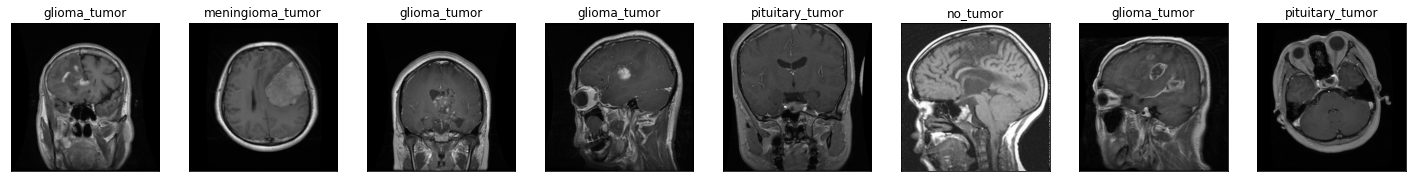

In [5]:
batch_size=8
num_workers=0


    # create and return DataLoaders
train_loader = DataLoader(dataset=brain_dataset_train, batch_size=batch_size, 
                          shuffle=True, num_workers=num_workers)

test_loader = DataLoader(dataset=brain_dataset_test, batch_size=batch_size, 
                         shuffle=True, num_workers=num_workers)

val_loader = DataLoader(dataset=brain_dataset_val, batch_size=batch_size, 
                         shuffle=True, num_workers=num_workers)


if Tumnor_detection:
    classes = ['tumor', 'no_tumor']
    num_classes=2
else:  
    # 0 for meningioma, 1 for glioma, 2 for pituitary tumor
    classes = ['meningioma_tumor','glioma_tumor', 'pituitary_tumor', 'no_tumor']
    num_classes=4

# # 
# classes = ['glioma_tumor','meningioma_tumor', 'pituitary_tumor']


import os
os.environ["KMP_DUPLICATE_LIB_OK"]  =  "TRUE"
fig = plt.figure(figsize=(25,25))

row_size=1
for i_batch, sample_batched in enumerate(test_loader):
    images_batch, labels_batch = sample_batched['image'], sample_batched['labels']
    print(images_batch.size())
    print(labels_batch.size())
    images_batch = images_batch.numpy()
    labels_batch = labels_batch.int()
    
    for idx in np.arange(batch_size):
        
        
        ax = fig.add_subplot(row_size, batch_size/row_size, idx+1, xticks=[], yticks=[])
        imshow(images_batch[idx])
        ax.set_title(classes[labels_batch[idx]])
    break


In [6]:

import torch.nn.functional as F

# define the CNN architecture
class myNet(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 5, padding=1, stride=2)
#         self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1, stride=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv5 = nn.Conv2d(128, 128, 3, padding=1)
        self.conv6 = nn.Conv2d(128, 256, 3, padding=1)
        
#         self.norm1 = nn.BatchNorm2d(16)
#         self.norm2 = nn.BatchNorm2d(32)
#         self.norm3 = nn.BatchNorm2d(64)
#         self.norm4 = nn.BatchNorm2d(128)
        
        # max pooling layer
        self.pool1 = nn.MaxPool2d((2, 2))
        self.pool2 = nn.MaxPool2d((2, 2),2)
        #linear layer (512 -> 2)
        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(64, 4)
#         self.fc1 = nn.Linear(2048, 1024)
#         self.fc2 = nn.Linear(1024, 4)

        self.dropout1 = nn.Dropout(0.25)
#         self.dropout2 = nn.Dropout(0.1)
#         self.dropout3 = nn.Dropout(0.5)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x =  F.relu(self.conv1(x))
        x = self.pool2(self.dropout1(x))
#         print(x.size())
        x = F.relu(self.conv2(x))
        x = self.pool2(self.dropout1(x))
#         print(x.size())
        x =  F.relu(self.conv3(x))
        x = self.pool2(self.dropout1(x))
#         print(x.size())
        x =  F.relu(self.conv4(x))
        x = self.pool1(self.dropout1(x))
#         print(x.size())
        x =  F.relu(self.conv5(x))
        x = self.pool1(self.dropout1(x))
#         print(x.size())
        x =  F.relu(self.conv6(x))
        x = self.pool1(self.dropout1(x))

        # flatten image input
        x = torch.flatten(x, 1)
#         x = x.reshape(8,-1)
#         print(x.size())
#         torch.reshape(x, (-1,2048))
        # add dropout layer
        
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
#         x = self.dropout2(x)
        x = self.fc2(x)
        x = F.softmax(x)
        return x

# # create a complete CNN
# # model = Net()


In [7]:
# from Models.Discriminator_ResidualAttentionNetwork3232ACC69 import ResidualAttentionModel_92_32input_update
# from Models.Discriminator_ResNet import resnet152, resnet101, resnet50
# from Models.Discriminator_VGG import vgg19, vgg19_bn
# from Models.Discriminator_efficientnet import efficientnet_b0
# from Models.Discriminator_densenet import DenseNet, densenet201
# from Models.Discriminator_shufflenetv2 import shufflenet_v2_x2_0
# from Models.Discriminator_mobilenetv3 import mobilenet_v3_large, mobilenet_v3_small
# from Models.Discriminator_mnasnet import mnasnet1_0
# from Models.Discriminator_regnet import regnet_x_32gf
# from Models.Discriminator_visiontransformer import VisionTransformer, CONFIGS, AverageMeter
# from Models.Discriminator_crossvit import CrossViT
# from Models.Discriminator_focal_transformer import FocalTransformer
# from Models.Discriminator_imagetransformer import ImageTransformer
from Models.research256_light_classifierACC59 import Net

# model=ResidualAttentionModel_92_32input_update()
# model=resnet152(num_classes=num_classes)
# from research256_light_classifierACC59 import Net
# model=Net()
# model = efficientnet_b0(num_classes=num_classes)
# model = DenseNet(num_classes=num_classes)
# model = shufflenet_v2_x2_0(num_classes=num_classes)
# model = mobilenet_v3_large(num_classes=num_classes)
# model = densenet201(num_classes=num_classes)
# model = vgg19(num_classes=num_classes)
# model = mnasnet1_0(num_classes=num_classes)
# model = regnet_x_32gf(num_classes=num_classes)

# config = CONFIGS["ViT-B_16"]#choices=["ViT-B_16", "ViT-B_32", "ViT-L_16","ViT-L_32", "ViT-H_14", "R50-ViT-B_16"]
# model = VisionTransformer(config,img_size=thesize, num_classes=num_classes)

# model = CrossViT(112, 1, 4)
# model = FocalTransformer(img_size=thesize, in_chans=1,num_classes=num_classes,embed_dim=128, depths=[2,2,18,2], drop_path_rate=0.2, 
#         focal_levels=[2,2,2,2], expand_sizes=[3,3,3,3], expand_layer="all", 
#         num_heads=[4,8,16,32],
#         focal_windows=[7,5,3,1], window_size=7,
#         use_conv_embed=False, use_shift=False, 
#     )

# model = ImageTransformer(image_size=256, patch_size=8, num_classes=num_classes, channels=1,
#             dim=64, depth=6, heads=8, mlp_dim=128)

model = Net()
if train_on_gpu:
    model.cuda()
criterion = nn.CrossEntropyLoss()


# optimizer
# optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=3e-4)

# # # specify optimizer
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

# criterion = torch.nn.MSELoss()
# criterion = torch.nn.MSELoss(reduction = 'sum')
# discriminator_criterion = lpips.LPIPS(net='vgg').cuda()
# discriminator_criterion = lpips.LPIPS().cuda()
optimizer = torch.optim.Adam(model.parameters())
model

Net(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=4, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
)

In [ ]:
n_epochs = 200

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for i_batch, sample_batched in enumerate(train_loader):
        images_batch,labels_batch = sample_batched['image'], sample_batched['labels']
        img=images_batch.float()
        target = labels_batch.long()
        if train_on_gpu:
            img, target = img.cuda(), target.cuda()
    
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(img)
#         print(target)

        # calculate the batch loss
#         print(output,output.size())
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*img.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for i_batch, sample_batched in enumerate(val_loader):
        images_batch,labels_batch = sample_batched['image'], sample_batched['labels']
        img=images_batch.float()
        target = labels_batch.long()
        if train_on_gpu:
            img, target = img.cuda(), target.cuda()
        output = model(img)
        
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*img.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(test_loader.sampler)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

C:\Users\13862\Desktop\AMLS_assignment\Models\research256_light_classifierACC59.py:49: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


Epoch: 1 	Training Loss: 1.328663 	Validation Loss: 1.302933
Validation loss decreased (inf --> 1.302933).  Saving model ...
Epoch: 2 	Training Loss: 1.248350 	Validation Loss: 1.281911
Validation loss decreased (1.302933 --> 1.281911).  Saving model ...
Epoch: 3 	Training Loss: 1.232411 	Validation Loss: 1.449774
Epoch: 4 	Training Loss: 1.454918 	Validation Loss: 1.449964


In [ ]:
# model.load_state_dict(torch.load('research256_light_classifierACC59.pt'))
model.load_state_dict(torch.load('model_cifar.pt'))

In [ ]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(20))
class_total = list(0. for i in range(20))

model.eval()
# iterate over test data
counter=0
for i_batch, sample_batched in enumerate(test_loader):
    images_batch, labels_batch = sample_batched['image'], sample_batched['labels']
    img=images_batch.float()
    target = labels_batch.long()
    if train_on_gpu:
        img,  target = img.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(img)[0]
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*img.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
#         print(counter)
        if counter==300:
            break
        label = target.data
        class_correct[label] += correct.item()
#         label = target[i].data
#         class_correct[label] += correct[i].item()
        class_total[label] += 1
        counter += 1
       

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(num_classes):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))



In [ ]:
dataiter = iter(test_loader)
sample_batched = dataiter.next()
images_batch, labels_batch = sample_batched['image'], sample_batched['labels']
img=images_batch.float()
target = labels_batch.long()
if train_on_gpu:
    img,  target = img.cuda(), target.cuda()

# get sample outputs
output = model(img)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25,25))
# display 20 images
for idx in np.arange(batch_size):
    ax = fig.add_subplot(8, batch_size/8, idx+1, xticks=[], yticks=[])
    imshow(img.cpu()[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[target[idx]]),
                 color=("green" if preds[idx]==target[idx].item() else "red"))